<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import xgboost as xgb

In [2]:
df = pd.read_csv('/datasets/taxi.csv')

Узнаем размер таблицы и данные

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [4]:
df.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


Проверим количество явных дубликотв и при наличии избавимся от них

In [5]:
df.duplicated().sum()

0

Проверим количество пропусков и при наличии избавимся от них

In [6]:
df.isna().sum()

datetime      0
num_orders    0
dtype: int64

In [7]:
df['num_orders'] = pd.to_numeric(df['num_orders'], errors='coerce')
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.set_index('datetime')

# Ресемплирование данных по одному часу
df = df.resample('1H').sum()

## Анализ

Вычислим основные статистические характеристики данных о заказах:

In [8]:
df['num_orders'].describe()

count    4416.000000
mean       84.422781
std        45.023853
min         0.000000
25%        54.000000
50%        78.000000
75%       107.000000
max       462.000000
Name: num_orders, dtype: float64

Проведем анализ трендов и сезонности с помощью метода декомпозиции временных рядов:

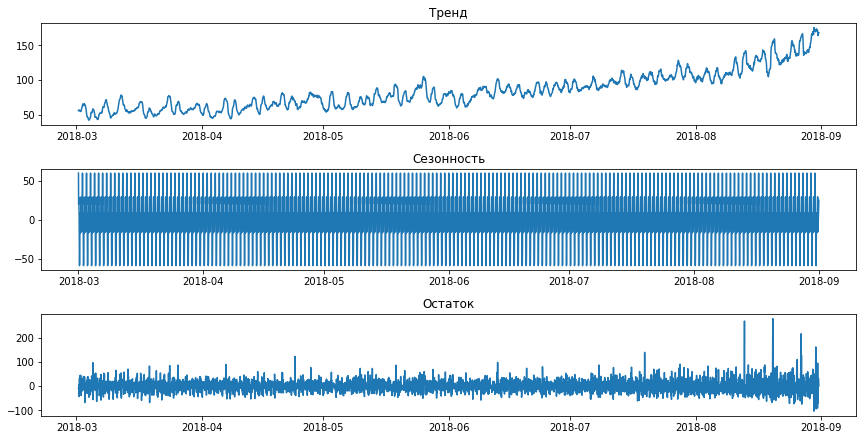

In [9]:
# Декомпозиция временных рядов
decomposition = seasonal_decompose(df['num_orders'], model='additive')

# Визуализация декомпозиции
plt.figure(figsize=(12, 8))
plt.subplot(4, 1, 1)
plt.plot(df.index, decomposition.trend)
plt.title('Тренд')
plt.subplot(4, 1, 2)
plt.plot(df.index, decomposition.seasonal)
plt.title('Сезонность')
plt.subplot(4, 1, 3)
plt.plot(df.index, decomposition.resid)
plt.title('Остаток')
plt.tight_layout()
plt.show()

Для более показательных графиков уменьшим интервал до недели

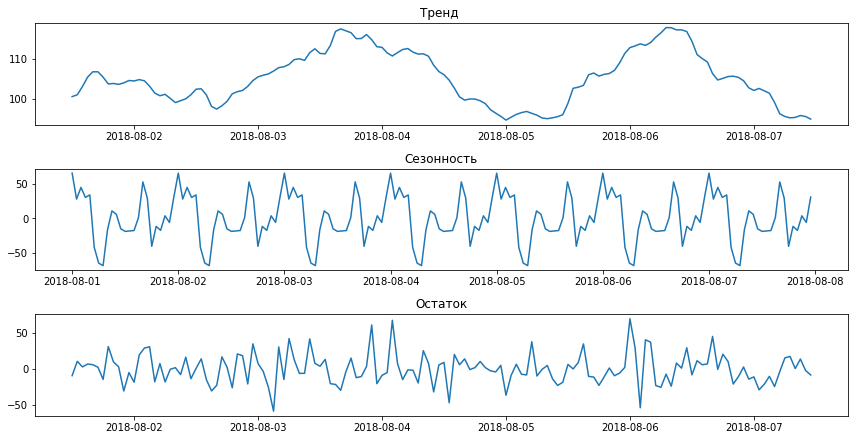

In [10]:
start_date = '2018-08-01'
end_date = '2018-08-07'
selected_data = df[start_date:end_date]

# Декомпозиция временных рядов
decomposition = seasonal_decompose(selected_data['num_orders'], model='additive')

# Визуализация декомпозиции
plt.figure(figsize=(12, 8))
plt.subplot(4, 1, 1)
plt.plot(selected_data.index, decomposition.trend)
plt.title('Тренд ')
plt.subplot(4, 1, 2)
plt.plot(selected_data.index, decomposition.seasonal)
plt.title('Сезонность')
plt.subplot(4, 1, 3)
plt.plot(selected_data.index, decomposition.resid)
plt.title('Остаток')
plt.tight_layout()
plt.show()

Тренд на графике декомпозиции растет на 4 числа, затем падает и снова растет на 6 чисел, что может указывать на наличие периодической сезонности или цикличности в данных.

Сезонность на графике декомпозиции является однородной. Это означает, что поведение заказов в определенное время дня или дня недели остается стабильным в течение этого периода.

In [11]:
def make_features(df, max_lag, rolling_sum_size):
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour

    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_sum'] = df['num_orders'].shift().rolling(rolling_sum_size).sum()

    # Удалить строки с пропущенными значениями
    df = df[max_lag + rolling_sum_size - 1:]

    return df

Создадим функцию make_features,которая выполняет следующие операции:

Добавляет фактор дня (day): Разделяет временные метки на дни месяца, что может помочь учесть изменения в поведении заказов внутри каждого месяца.

Добавляет фактор дня недели (dayofweek): Разделяет временные метки на дни недели, чтобы учесть возможные сезонные или циклические изменения, связанные с конкретными днями недели (например, повышенный спрос по выходным или пониженный спрос в будние дни).

Добавляет фактор часа (hour): Разделяет временные метки на часы дня, чтобы учесть часовые изменения в поведении заказов (например, пики активности в определенные часы дня).

Добавляет лаги (lag): Создает отстающие значения (лаги) для столбца num_orders, смещая его на заданное количество временных шагов. Это позволяет учесть зависимость текущих заказов от предыдущих значений и захватить возможные временные закономерности.

Добавляет скользящую сумму (rolling_sum): Рассчитывает скользящую среднюю для столбца num_orders со сдвигом на один временной шаг. Это позволяет учесть сглаженные тренды или общую динамику данных.

Эти операции помогают расширить исходные данные и добавить дополнительные признаки, которые могут быть полезны для анализа и прогнозирования временных рядов заказов. 

In [12]:
df_features = make_features(df, max_lag=47, rolling_sum_size=50)


## Обучение

In [13]:
# Подготовка признаков с помощью функции make_features
df_features = make_features(df, max_lag=47, rolling_sum_size=50)

# Разделение на обучающую и тестовую выборки
train_df, test_df = train_test_split(df_features, test_size=0.1, shuffle=False)

# Создание матрицы признаков и вектора целевой переменной для обучающей выборки
X_train = train_df.drop('num_orders', axis=1)
y_train = train_df['num_orders']

In [14]:
# Создание объекта TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=10)

# Определение модели линейной регрессии
linear_regression = LinearRegression()
linear_regression.fit(X_train, y_train)

# Определение модели решающего дерева
decision_tree = DecisionTreeRegressor()

# Определение модели случайного леса
random_forest = RandomForestRegressor()

# Задание сетки параметров для перебора
param_grid = {
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [100, 200, 300]
}

In [15]:
# Создание объектов GridSearchCV для каждой модели
linear_regression_grid = GridSearchCV(estimator=linear_regression, param_grid={}, scoring='neg_mean_squared_error', cv=tscv)
decision_tree_grid = GridSearchCV(estimator=decision_tree, param_grid={'max_depth': [5, 10, 15], 'min_samples_split': [2, 5, 10]}, scoring='neg_mean_squared_error', cv=tscv)
random_forest_grid = GridSearchCV(estimator=random_forest, param_grid={'max_depth': [5, 10, 15], 'min_samples_split': [2, 5, 10], 'n_estimators': [100, 200, 300]}, scoring='neg_mean_squared_error', cv=tscv)

# Обучение моделей с перебором гиперпараметров
linear_regression_grid.fit(X_train, y_train)
decision_tree_grid.fit(X_train, y_train)
random_forest_grid.fit(X_train, y_train)

# Получение наилучших параметров для каждой модели
best_linear_regression_params = linear_regression_grid.best_params_
best_decision_tree_params = decision_tree_grid.best_params_
best_random_forest_params = random_forest_grid.best_params_

# Вывод результатов
print('Linear Regression Best Parameters:', best_linear_regression_params)
print('Decision Tree Best Parameters:', best_decision_tree_params)
print('Random Forest Best Parameters:', best_random_forest_params)

Linear Regression Best Parameters: {}
Decision Tree Best Parameters: {'max_depth': 5, 'min_samples_split': 10}
Random Forest Best Parameters: {'max_depth': 15, 'min_samples_split': 2, 'n_estimators': 300}


In [16]:
# Создание моделей с лучшими гиперпараметрами
best_linear_regression = LinearRegression(**best_linear_regression_params)
best_decision_tree = DecisionTreeRegressor(**best_decision_tree_params)
best_random_forest = RandomForestRegressor(**best_random_forest_params)


In [17]:
# Обучение моделей
best_linear_regression.fit(X_train, y_train)
best_decision_tree.fit(X_train, y_train)
best_random_forest.fit(X_train, y_train)

# Получение предсказаний 
linear_regression_train_predictions = best_linear_regression.predict(X_train)
decision_tree_train_predictions = best_decision_tree.predict(X_train)
random_forest_train_predictions = best_random_forest.predict(X_train)

# Расчет MSE 
linear_regression_train_mse = mean_squared_error(y_train, linear_regression_train_predictions)
decision_tree_train_mse = mean_squared_error(y_train, decision_tree_train_predictions)
random_forest_train_mse = mean_squared_error(y_train, random_forest_train_predictions)


In [18]:
# Расчет RMSE 
linear_regression_train_rmse = np.sqrt(linear_regression_train_mse)
decision_tree_train_rmse = np.sqrt(decision_tree_train_mse)
random_forest_train_rmse = np.sqrt(random_forest_train_mse)

# Вывод результатов
print('Linear Regression RMSE on Train Data:', linear_regression_train_rmse)
print('Decision Tree RMSE on Train Data:', decision_tree_train_rmse)
print('Random Forest RMSE on Train Data:', random_forest_train_rmse)

Linear Regression RMSE on Train Data: 24.17886371729025
Decision Tree RMSE on Train Data: 24.806514203951725
Random Forest RMSE on Train Data: 9.211365420352834


Исходя из этих значений, наилучшей моделью является Случайный лес (Random Forest), так как она имеет наименьшее значение MSE. Это означает, что случайный лес демонстрирует лучшую предсказательную способность по сравнению с другими моделями в данной задаче. Используем ее для тестирования

## Тестирование

In [19]:
# Преобразование признаков
X_test = test_df.drop('num_orders', axis=1)
y_test = test_df['num_orders']


In [20]:
# Создание модели случайного леса с лучшими гиперпараметрами
best_random_forest = RandomForestRegressor(
    max_depth=15,
    min_samples_split=2,
    n_estimators=200,
    max_features='sqrt',
    min_samples_leaf=2
)

# Обучение модели с лучшими гиперпараметрами на обучающей выборке
best_random_forest.fit(X_train, y_train)

# Получение предсказаний для тестовой выборки
random_forest_predictions_test = best_random_forest.predict(X_test)

# Расчет MSE на тестовой выборке
random_forest_mse_test = mean_squared_error(y_test, random_forest_predictions_test)


In [21]:
# Расчет RMSE на тестовой выборке для модели случайного леса
random_forest_rmse_test = np.sqrt(random_forest_mse_test)

# Вывод результатов
print('Random Forest RMSE:', random_forest_rmse_test)

Random Forest RMSE: 44.81986838521805


На основе этого результата можно сделать вывод, что модель случайного леса достаточно точно предсказывает количество заказов в данной задаче.